In [3]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    !pip install umap-learn
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [4]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np

from six.moves import xrange
import datetime
import gc

from scipy import signal
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

In [5]:
model_name = "AE_batch_size_56_num_hiddens_64__day_17_hour_0_final.pth"
config = torch.load(f'config_{model_name}')
model = AE(num_hiddens=config["num_hiddens"]).to(device)
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas_new.pth')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas_new.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

y = torch.load("training_labels_list.pth",  map_location=torch.device('cpu'))
X = torch.load("training_samples_list_torch.pth",  map_location=torch.device('cpu'))
X = X[0:6000]

FileNotFoundError: [Errno 2] No such file or directory: 'config_AE_batch_size_56_num_hiddens_64__day_17_hour_0_final.pth'

In [4]:
training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

## **Batch Clustering**

In [ ]:
clusters = [2]
for n_cluster in clusters:
    print(f"current cluster: {n_cluster}")
    iterator_Dataset = iter(training_loader)
    testing = TestModel(model, iterator_Dataset, device=torch.device("cuda"))
    Clustering = AE_Clustering(testing, training_loader, n_clusters=n_cluster)
    kmeans = Clustering.fordward()
    Clustering.plot_centroids()
    plt.savefig(f"Clustering_Results/Figures/Clustering_centroids_{n_cluster}.pdf", format="pdf")
    output.clear()

In [ ]:
Clustering.plot_centroids()
plt.savefig(f"Clustering_Results/Figures/Clustering_centroids_TSNE_7.pdf", format="pdf")

## **Traditional clustering**

In [5]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm

# Single methods
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples

In [21]:
def plot_silhouette( X, cluster_labels, n_clusters, silhouette_avg):
    fig, ax1 = plt.subplots(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    print("Ya debio plotear")
    # plt.savefig(f"Clustering_Results/Figures/Clustering_plot_{n_clusters}_{method}.pdf", format="pdf")
    # plt.show()

def plot_centroids(cluster_centers, testing, method):
    plt.figure(figsize=(18, 18))
    testing._model.to("cpu")
    for i, spec in enumerate(cluster_centers):
        encodings = spec.reshape(64,9,9)
        encodings = torch.tensor(encodings).float()
        decodings = testing._model.decoder(encodings).detach().numpy()
        plt.subplot(6, 6, i + 1)
        plt.imshow(decodings[0, :, :], origin="lower", cmap="viridis")
        plt.xticks(())
        plt.yticks(())
    # plt.savefig(f"Clustering_Results/Figures/Clustering_plot_{n_cluster}_{method}.pdf", format="pdf")

For n_clusters = 3 The average silhouette_score is : 0.61553
Ya debio plotear
(1, 515, 515)
(1, 515, 515)
(1, 515, 515)


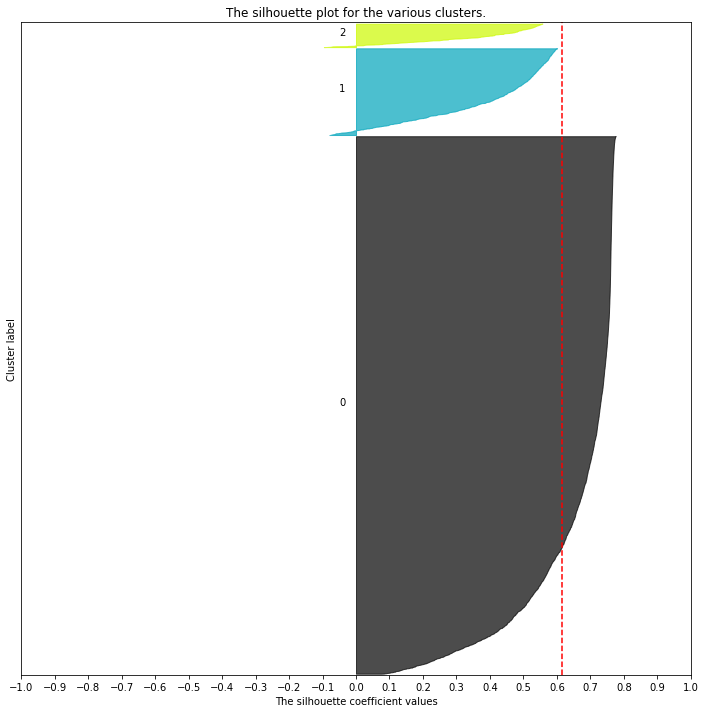

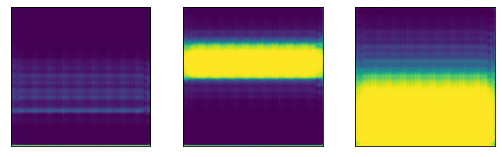

In [23]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
silhouette_score = metrics.silhouette_score(X, kmeans.labels_)
plot_silhouette(X, kmeans.labels_, kmeans.n_clusters, silhouette_score)
plot_centroids(kmeans.cluster_centers_, testing,"n")